<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Judy/From%20Colab/Combined_10stocks_Peter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   8494      0 --:--:-- --:--:-- --:--:--  8494
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 36 kB/s 
     |████████████████████████████████| 1.0 MB 41.3 MB/s 
+ set +ex
Installation succeeded!


### Deep Learning Barrier Option

We used Numba and CuPy in the previous notebook to run Monte Carlo simulation to determine the price of the Asian Barrier option. A Monte Carlo simulation needs millions of paths to get an accurate answer which is computationally intensive. [Ryan et al (2018)](https://arxiv.org/abs/1809.02233) showed that a deep learning model can be trained to value derivatives. The deep learning model is accurate and very fast, capable of producing valuations a million times faster than traditional models. In the this notebook, we will use a fully connected network to learn the pricing mode of the Asian Barrier option. Monte Carlo simulation is used as pricing ground truth for the training. We use the same Asian Barrier Option model as last notebook with parameters listed as following:

```
T - Maturity (yrs.)
S - Spot (usd)
K - Strike (usd)
sigma - Volatility (per.)
r - Risk Free Rate (per.)
mu - Stock Drift Rate (per.)
B - Barrier (usd)
```

### Batched Data generation

The dataset is an important part of the Deep learning training. We will modify the previous single Asian Barrier Option pricing code to handle a batch of Barrier Option pricing. 

In [ ]:
#@title
###Test: Judy's new X code
#N_STOCKS = 3

In [ ]:
#@title
#X = cupy.array([])
#for i in range(0,N_STOCKS):
  #X =  cupy.concatenate((X,cupy.array([1,1]), cupy.random.rand(3),cupy.array([1])))
#X = X.reshape(N_STOCKS,6)
#X

array([[1.        , 1.        , 0.05103263, 0.0071633 , 0.52167781,
        1.        ],
       [1.        , 1.        , 0.64857557, 0.32324551, 0.39745689,
        1.        ],
       [1.        , 1.        , 0.82301291, 0.46666519, 0.8391176 ,
        1.        ]])

In [ ]:
#@title
#X = X * ((cupy.array([200.0, 0, 200.0, 0.4, 0.2, 0.2] * N_STOCKS, dtype = cupy.float32)).reshape(N_STOCKS, 6))
#X

array([[2.00000000e+02, 0.00000000e+00, 1.02065252e+01, 2.86532070e-03,
        1.04335564e-01, 2.00000003e-01],
       [2.00000000e+02, 0.00000000e+00, 1.29715113e+02, 1.29298207e-01,
        7.94913799e-02, 2.00000003e-01],
       [2.00000000e+02, 0.00000000e+00, 1.64602581e+02, 1.86666078e-01,
        1.67823523e-01, 2.00000003e-01]])

# Train (Erin Version)

In [3]:
################################# TEST ########################################
%%writefile cupy_dataset.py

import numba
from numba import cuda
import random
import cupy
import numpy as np
import math
import time
import torch
cupy.cuda.set_allocator(None)
from torch.utils.dlpack import from_dlpack

@cuda.jit
def batch_barrier_option(d_s, T, K, B, S0, sigma, mu, r, d_normals, N_STEPS, N_PATHS, N_BATCH):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.gridDim.x * cuda.blockDim.x
    tmp3 = math.sqrt(T/N_STEPS)
    for i in range(ii, N_PATHS * N_BATCH, stride):
        batch_id = i // N_PATHS
        path_id = i % N_PATHS
        tmp1 = mu[batch_id]*T/N_STEPS
        tmp2 = math.exp(-r[batch_id]*T)
        running_average = 0.0
        s_curr = S0[batch_id]
        for n in range(N_STEPS):
            s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH] # stock price
            running_average = running_average + 1.0/(n + 1.0) * (s_curr - running_average) # average of the path
            if i==0 and batch_id == 2:
                print(s_curr)
            if running_average <= B[batch_id]: # if reach barrier, drop out the path
                break
        payoff = running_average - K[batch_id] if running_average > K[batch_id] else 0
        d_s[i] = tmp2 * payoff

class NumbaOptionDataSet(object):
    
    def __init__(self, max_len=10, number_path = 1000, batch=2, threads=512, seed=15, stocks=10): #We have 10 stocks  ### remember to change this 1!
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 365
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = np.float32(1.0)
        self.output = cupy.zeros(self.N_STOCKS*self.N_PATHS, dtype=cupy.float32) 
        self.number_of_blocks = (self.N_PATHS * self.N_STOCKS - 1) // threads + 1
        self.number_of_threads = threads
        cupy.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num > self.max_length:
            raise StopIteration
        
        Y = cupy.zeros(self.N_BATCH, dtype=cupy.float32)
        paras = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)
        for op in range(self.N_BATCH):
          X = cupy.array([])
          K_rand = cupy.random.rand(1)[0]
          B_rand = cupy.random.rand(1)[0]
          r_rand = cupy.random.rand(1)[0]
          for i in range(0,self.N_STOCKS):
            X =  cupy.concatenate((X,cupy.array([K_rand,B_rand]), cupy.random.rand(3),cupy.array([r_rand])))  #[K,B,S0,sigma,mu,r](Each stock has 6 inputs)
          X = X.reshape(self.N_STOCKS,6)
          X = X * ((cupy.array([200.0, 0.1, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6))
          
          for i in range(self.N_STOCKS):
            paras[op,i*6:(i+1)*6] = X[i,:] #存input

          stocks_randoms_mean = cupy.zeros(self.N_STOCKS, dtype = cupy.float32)
          rho = cupy.random.normal(0, 1, self.N_STOCKS, dtype = cupy.float32)

          stocks_randoms_cov = cupy.array([1] * self.N_STOCKS*self.N_STOCKS, dtype = cupy.float32).reshape(self.N_STOCKS,self.N_STOCKS)  #Covariance
          cupy.fill_diagonal(stocks_randoms_cov, 1)

          num_of_randoms_each_stock = self.N_PATHS * self.N_STEPS
          randoms_gpu = cupy.random.multivariate_normal(stocks_randoms_mean, stocks_randoms_cov,
                                                        num_of_randoms_each_stock, dtype=cupy.float32)
          b1_r = randoms_gpu[:,0]
          b2_r = randoms_gpu[:,1]
          randoms = cupy.zeros(self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
          interval = int((self.N_PATHS * self.N_STEPS * self.N_STOCKS) / self.N_PATHS)
          for i in range(interval):
            if i % 2 == 0:
                ind = int(i/2)
                randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b1_r[ind:(ind+self.N_PATHS)]
            else:
                ind = int(i//2)
                randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b2_r[ind:(ind+self.N_PATHS)]

          randoms = cupy.random.normal(0, 1, self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
          batch_barrier_option[(self.number_of_blocks,), (self.number_of_threads,)](self.output, self.T, X[:, 0], 
                                X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], randoms, self.N_STEPS, self.N_PATHS, self.N_STOCKS)
          
          o = self.output.reshape(self.N_STOCKS, self.N_PATHS)
          Y[op] = o.mean(axis = 0).mean()

        self.num += 1
        return (from_dlpack(paras.toDlpack()), from_dlpack(Y.toDlpack()))



# ds = NumbaOptionDataSet(10, number_path=100000, batch=3, seed=random.randint(0,100), stocks=5)
# for i in ds:
#     print(i[0])
################################# TEST ########################################

Writing cupy_dataset.py


In [39]:
cupy.random.rand(1)

array([0.59049504])

### Model
To map the option parameters to price, we use 6 layers of fully connected neural network with hidden dimension 512 as inspired by [this paper](https://arxiv.org/abs/1809.02233). Writing this DL price model into a file `model.py`:-

### Modified Model

In [4]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np


class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(60, hidden) ### remember to change this2!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        
        self.register_buffer('norm',
                             torch.tensor([200.0, 0.1, 200.0, 0.4, 0.2, 0.2]*10)) #6 inputs * 10 stocks  ### remember to change this2!

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


As we know the random parameters' scaling factors, the input parameters are first scaled back to a range of (0-1) by dividing them by (200.0, 198.0, 200.0, 0.4, 0.2, 0.2). Then they are projected 5 times to the hidden dimension of 512 after the `ELu` activation function. `ELu` is chosen because we need to compute the second order differentiation of the parameters. If use ReLu, the second order differentiation will always be zero. The last layer is a linear layer that maps the hidden dimension to the predicted option price. 

For training, we use [Ignite](https://github.com/pytorch/ignite) which is a high-level library to train neural networks in PyTorch. We use `MSELoss` as the loss function, `Adam` as the optimizer and `CosineAnnealingScheduler` as the learning rate scheduler. The following code is feeding the random option data to the pricing model to train it.

### Train

In [5]:
!pip install pytorch-ignite

     |████████████████████████████████| 221 kB 14.0 MB/s 


In [ ]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import NumbaOptionDataSet
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = NumbaOptionDataSet(max_len=100, number_path = 1024, batch=32, stocks=10)  # remember to change this4!

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs=100)

loss 756.2080078125 average time 0.46054010170000054 iter num 20
loss 610.3045654296875 average time 0.2322537454500015 iter num 40
loss 1349.194580078125 average time 0.15615080651666535 iter num 60
loss 559.3448486328125 average time 0.11805885198749806 iter num 80
loss 625.5225830078125 average time 0.09524226950999946 iter num 100
loss 268.63336181640625 average time 0.06712234860001161 iter num 20
loss 104.58335876464844 average time 0.03548245622500303 iter num 40
loss 60.53202819824219 average time 0.024965869783333497 iter num 60
loss 60.3089599609375 average time 0.019666976925000766 iter num 80
loss 75.8586654663086 average time 0.016483265439999287 iter num 100
loss 23.96868896484375 average time 0.06289682700000583 iter num 20
loss 27.16643714904785 average time 0.03337579967500517 iter num 40
loss 15.160030364990234 average time 0.023492455466674757 iter num 60
loss 13.283747673034668 average time 0.018533703625008967 iter num 80
loss 21.146249771118164 average time 0.0156

State:
	iteration: 10000
	epoch: 100
	epoch_length: 100
	max_epochs: 100
	output: 10.245476722717285
	batch: <class 'tuple'>
	metrics: <class 'dict'>
	dataloader: <class 'cupy_dataset.NumbaOptionDataSet'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

$2365$ seconds The loss is keeping decreasing which means the pricing model can predict the option prices better. It takes about $12ms$ to compute one mini-batch in average, In the following sections, we will try to expore the full potentials of the GPU to accelerate the training.

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

In [ ]:
model_save_name = 'checkpoint11.pth'
path = F"/content/drive/MyDrive/AFP/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [6]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import torch
model_save_name = 'checkpoint16.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [8]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=60, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1, bias=True)
)


**Continue to train model**

In [ ]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import NumbaOptionDataSet
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = NumbaOptionDataSet(max_len=10000, number_path = 1024, batch=4800)
dataset = NumbaOptionDataSet(max_len=500, number_path = 1024, batch=32, stocks=10)

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs=10)

model_save_name = 'checkpoint16.pth'
path = F"/content/drive/MyDrive/AFP/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 4.1348347663879395 average time 0.4026646554999928 iter num 20
loss 1.435728907585144 average time 0.20279997324999927 iter num 40
loss 1.6369260549545288 average time 0.1361864799999997 iter num 60
loss 2.350376605987549 average time 0.10283448772500492 iter num 80
loss 1.1851980686187744 average time 0.08285211490000051 iter num 100
loss 4.4049482345581055 average time 0.06951202320833355 iter num 120
loss 2.919016122817993 average time 0.059982411249999194 iter num 140
loss 2.2285635471343994 average time 0.052847325499999445 iter num 160
loss 2.0978405475616455 average time 0.047288375944442705 iter num 180
loss 2.2506637573242188 average time 0.042840321884998506 iter num 200
loss 2.5443248748779297 average time 0.03919653059090768 iter num 220
loss 1.4530715942382812 average time 0.03616922999166595 iter num 240
loss 1.1303216218948364 average time 0.03360102411923287 iter num 260
loss 1.5339158773422241 average time 0.03140672964642956 iter num 280
loss 1.8403620719909668 a

In [ ]:
## 3hr47m
## 3hr 47m
## 3hr 49m
## 3hr 42m

### Inference and Greeks

We can load the model parameters and use it to do inference

In [9]:
import torch
inputs = torch.tensor([[110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*10]).cuda()  ## remember to change this 5!
model(inputs.float())

tensor([[10.7239]], device='cuda:0', grad_fn=<AddmmBackward>)

One of the benefits of building a deep learning model is that the [Greeks](<https://en.wikipedia.org/wiki/Greeks_(finance)#First-order_Greeks>) can be easily computed. 
We just need to take advantage of the auto-grad feature in Pytorch. We can use `grad` function to compute the first order differentiation for parameters 'K, B, S0, sigma, mu, r'

In [10]:
inputs = torch.tensor([[110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*10]).cuda() # remember to change this 6!
inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient

tensor([[ -0.0359, -27.4908,   0.0506,   1.4333,   1.6312,   6.9031,  -0.0575,
           2.4944,   0.0534,   1.2431,   2.4081,   9.2225,  -0.0462,  -1.2656,
           0.0476,   0.5115,   2.2357,  -1.5948,  -0.0324,   3.3159,   0.0521,
           1.7701,   2.1807,  -7.9342,  -0.0322, -13.1789,   0.0507,   0.7038,
           2.5402,  -3.9720,  -0.0426,  19.7333,   0.0510,   0.9745,   1.6752,
          -6.5318,  -0.0338,   3.3756,   0.0518,   0.9676,   4.6513,   0.2500,
          -0.0470,  -0.0701,   0.0525,   0.2207,   2.0688,   4.5880,  -0.0536,
         -17.2467,   0.0502,   1.0526,   2.6291,  -9.7484,  -0.0388,  22.3192,
           0.0476,   0.7967,   2.3806,  -9.0270]], device='cuda:0')

Here we are going to plot the Delta graph:-

#Delta

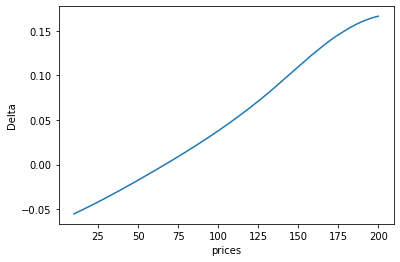

In [11]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S):
    inputs = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*9)]).cuda()  # remember to change this 7!
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(10, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

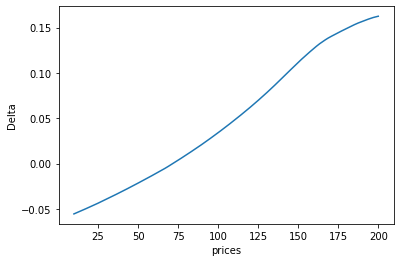

In [27]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np 
def compute_delta(S):
    inputs = torch.tensor([[110.0, 0.0, 110, 0.35, 0.1, 0.05]*2 + [110.0, 0.0, S, 0.35, 0.1, 0.05] + ([110.0, 0.0, 110, 0.35, 0.1, 0.05]*7)]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][14]
prices = np.arange(10, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

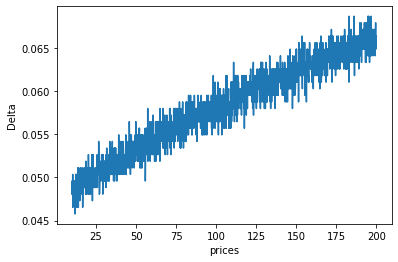

In [40]:
## Using Finite Difference, Change only 1 S0 at a time
%matplotlib inline
import numpy as np
def compute_delta(S):
    epsilon = 0.01
    inputs1 = torch.tensor([[110.0, 1, S, 0.35, 0.1, 0.05] + ([110.0, 1, 110.0, 0.35, 0.1, 0.05]*9)]).cuda()
    inputs2 = torch.tensor([[110.0,1, S + epsilon, 0.35, 0.1, 0.05] + ([110.0, 1, 110.0, 0.35, 0.1, 0.05]*9)]).cuda()
    delta = (model(inputs2.float()) - model(inputs1.float()))/epsilon
    return delta
prices = np.arange(10, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

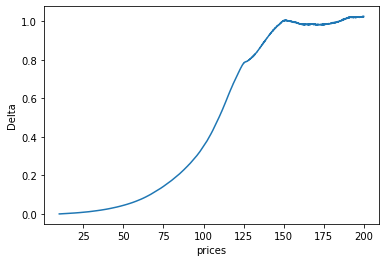

In [13]:
##Using Finite Difference, Change 10 S0 at a time
%matplotlib inline
import numpy as np
def compute_delta(S):
    epsilon = 0.01
    inputs1 = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05]*10]).cuda()
    inputs2 = torch.tensor([[110.0, 0.0, S + epsilon, 0.35, 0.1, 0.05]*10]).cuda()
    delta = (model(inputs2.float()) - model(inputs1.float()))/epsilon
    return delta
prices = np.arange(10, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

In [15]:
compute_delta(110)

tensor([[0.5079]], device='cuda:0', grad_fn=<DivBackward0>)

Calculating the second order derivative is easy in PyTorch too. We just need to apply the `grad` function twice. Use this mechanism, we can calculate the second order derivatives $\frac{\partial^2 P}{\partial K \partial S_0}$, $\frac{\partial^2 P}{\partial B \partial S_0}$, $\frac{\partial^2 P}{\partial S_0^2}$, $\frac{\partial^2 P}{\partial \sigma \partial S_0}$, $\frac{\partial^2 P}{\partial \mu \partial S_0}$, $\frac{\partial^2 P}{\partial r \partial S_0}$ in the following example.

# Gamma

In [14]:
import torch
from torch import Tensor
from torch.autograd import Variable
from torch.autograd import grad
from torch import nn

inputs = torch.tensor([[110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*10]).cuda()
inputs.requires_grad = True
x = model(inputs)

# instead of using loss.backward(), use torch.autograd.grad() to compute gradients
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
loss_grads = grad(x, inputs, create_graph=True)
drv = grad(loss_grads[0][0][2], inputs)
drv

(tensor([[-1.6961e-04, -1.3031e-01,  1.3092e-03,  7.7830e-03,  1.0169e-01,
           4.2482e-02, -1.4307e-04, -7.6294e-02,  4.0306e-05, -4.4477e-03,
           4.5833e-03,  2.8588e-02, -1.1784e-04, -1.2514e-02,  7.1528e-05,
          -1.1885e-03,  1.7626e-03,  5.6411e-03, -9.7218e-05,  3.4376e-02,
           6.5678e-05, -8.9826e-04,  4.8157e-03, -1.4418e-02, -8.2261e-05,
          -1.5146e-01,  2.6686e-05, -3.7225e-03, -3.7418e-03,  3.7795e-02,
          -1.8930e-04,  1.7673e-01,  2.8169e-05,  2.1283e-03, -5.3568e-03,
          -3.4843e-02, -1.2261e-04,  8.5315e-04,  3.9124e-05,  2.9197e-03,
           1.1010e-02,  3.9710e-04, -1.6080e-04,  7.4378e-02,  3.4125e-05,
          -2.9776e-03,  4.8121e-03, -3.3736e-02, -1.6368e-04,  3.6401e-04,
           7.1493e-05, -2.0259e-03,  7.9119e-03, -3.0767e-02, -1.4566e-04,
           3.5223e-02,  5.5643e-05, -2.4363e-03,  4.5123e-03, -9.9075e-02]],
        device='cuda:0'),)

Gamma is the second order differenation of `S`. We can plot the the Gamma curve as a function of the stock price

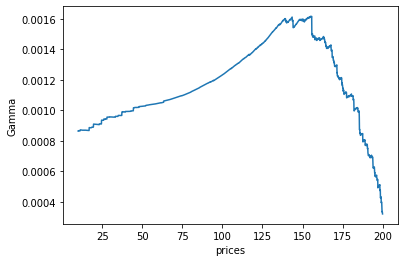

In [16]:
import pylab
import numpy as np
def compute_gamma(S):
    inputs = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*9)]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    loss_grads = grad(x, inputs, create_graph=True)
    drv = grad(loss_grads[0][0][2], inputs)
    return drv[0][0][2]

prices = np.arange(10, 200, 0.1)
gammas = []
for p in prices:
    gammas.append(compute_gamma(p).item())
fig2 = pylab.plot(prices, gammas)
pylab.xlabel('prices')
pylab.ylabel('Gamma')
fig2

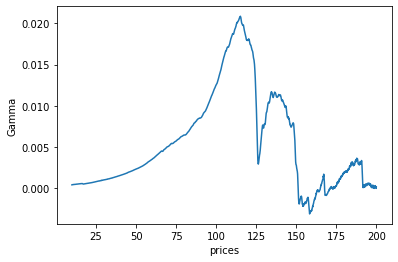

In [17]:
%matplotlib inline
import numpy as np
def compute_gamma(S):
    epsilon = 0.5
    inputs1 = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05]*10]).cuda()
    inputs2 = torch.tensor([[110.0, 0.0, S + epsilon, 0.35, 0.1, 0.05]*10]).cuda()
    inputs3 = torch.tensor([[110.0, 0.0, S - epsilon, 0.35, 0.1, 0.05]*10]).cuda()
    delta = (model(inputs2.float()) - 2*model(inputs1.float()) + model(inputs3.float()))/(epsilon**2)
    return delta
prices = np.arange(10, 200, 0.1)
gammas = []
for p in prices:
    gammas.append(compute_gamma(p).item())
fig = pylab.plot(prices, gammas)
pylab.xlabel('prices')
pylab.ylabel('Gamma')
fig

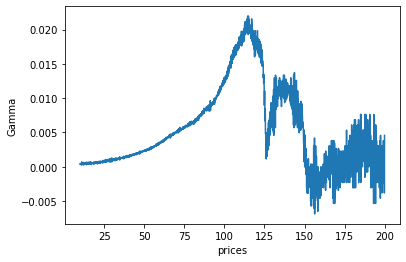

In [21]:
%matplotlib inline
import numpy as np
def compute_gamma(S):
    epsilon = 0.1
    inputs1 = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05]*10]).cuda()
    inputs2 = torch.tensor([[110.0, 0.0, S + epsilon, 0.35, 0.1, 0.05]*10]).cuda()
    inputs3 = torch.tensor([[110.0, 0.0, S - epsilon, 0.35, 0.1, 0.05]*10]).cuda()
    delta = (model(inputs2.float()) - 2*model(inputs1.float()) + model(inputs3.float()))/(epsilon**2)
    return delta
prices = np.arange(10, 200, 0.1)
gammas = []
for p in prices:
    gammas.append(compute_gamma(p).item())
fig = pylab.plot(prices, gammas)
pylab.xlabel('prices')
pylab.ylabel('Gamma')
fig

# Vega

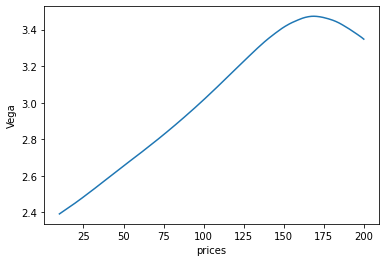

In [18]:
# vega
%matplotlib inline
import numpy as np
def compute_vega(S):
    epsilon = 0.5
    inputs1 = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*9)]).cuda()
    inputs2 = torch.tensor([[110.0, 0.0, S, 0.35 + epsilon, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*9)]).cuda()
    vega = (model(inputs2.float()) - model(inputs1.float()))/epsilon
    return vega
prices = np.arange(10, 200, 0.1)
vegas = []
for p in prices:
    vegas.append(compute_vega(p).item())
fig = pylab.plot(prices, vegas)
pylab.xlabel('prices')
pylab.ylabel('Vega')
fig

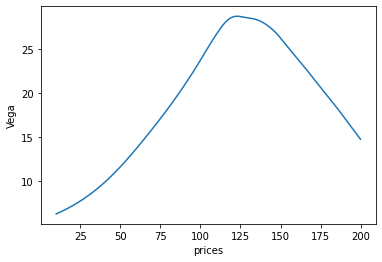

In [19]:
# vega
%matplotlib inline
import numpy as np
def compute_vega(S):
    epsilon = 0.5
    inputs1 = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05]*10]).cuda()
    inputs2 = torch.tensor([[110.0, 0.0, S, 0.35 + epsilon, 0.1, 0.05]*10]).cuda()
    vega = (model(inputs2.float()) - model(inputs1.float()))/epsilon
    return vega
prices = np.arange(10, 200, 0.1)
vegas = []
for p in prices:
    vegas.append(compute_vega(p).item())
fig = pylab.plot(prices, vegas)
pylab.xlabel('prices')
pylab.ylabel('Vega')
fig

[Implied volatility](https://en.wikipedia.org/wiki/Implied_volatility) is the forecasted volatility of the underlying asset based on the quoted prices of the option. It is the reverse mapping of price to the option parameter given the model which is hard to do with the Monte Carlo simulation approach. But if we have the deep learning pricing model, it is an easy task. We can first plot the relationship between volatility and the option price

In [20]:
import pylab
import numpy as np
def compute_price(sigma):
    inputs = torch.tensor([[110.0, 0.0, 110.0, sigma, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
    x = model(inputs.float())
    #x = model(inputs)
    return x.item()
sigmas = np.arange(0, 0.5, 0.1)
prices = []
for s in sigmas:
    prices.append(compute_price(s))
fig3 = pylab.plot(sigmas, prices)
pylab.xlabel('Sigma')
pylab.ylabel('Price')
fig3

RuntimeError: ignored

Given the prices `P`, the implied volatility is the root of the function `compute_price`. We can use bisection to find the root.

In [ ]:
def bisection_root(small, large, fun, target, EPS=1e-6):
    if fun(large) - target < 0:
        print('upper bound is too small')
        return None
    if fun(small) - target > 0:
        print('lower bound is too large')
        return None
    while large - small > EPS:
        mid = (large + small) / 2.0
        if fun(mid) - target >= 0:
            large = mid
        else:
            small = mid
    mid = (large + small) / 2.0
    return mid, abs(fun(mid) - target)
quoted_price = 16.0
sigma, err = bisection_root(0, 0.5, compute_price, quoted_price)
print('implied volativity', sigma, 'error', err)     

upper bound is too small


TypeError: ignored